<a href="https://colab.research.google.com/github/pomeshiba29/customer-churn-prediction/blob/main/%E9%A1%A7%E5%AE%A2%E8%A7%A3%E7%B4%84%E4%BA%88%E6%B8%AC%E3%83%A2%E3%83%87%E3%83%AB_v1.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
file_path = '/content/drive/MyDrive/Qiitaドキュメント作成/顧客解約予測/サンプル顧客データ.csv'

In [6]:
#SHAPとxgboostのインポート
!pip install shap xgboost

In [7]:
#必要ライブラリのインポート
# 必要ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_score,
    recall_score, f1_score, precision_recall_curve
)

In [8]:
# CSVの読み込み
df = pd.read_csv(file_path)

In [9]:
# 不要カラムの削除 + 目的変数分離
df_features = df.drop(columns=['Partner', 'Dependents', 'customerID', 'Churn'])
df_target = df['Churn'].map({'No': 0, 'Yes': 1})

# TotalChargesの欠損補完
df_features['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# === ✅ 特徴量エンジニアリング ===

# 契約スコア（契約期間の長さを数値化）
df_features['contract_score'] = df['Contract'].map({
    'Month-to-month': 0, 'One year': 1, 'Two year': 2
})

# アドオンサービスのYes数カウント
addon_cols = ['OnlineSecurity', 'OnlineBackup', 'TechSupport', 'DeviceProtection']
df_features['addon_count'] = df[addon_cols].eq('Yes').sum(axis=1)

# 平均月額請求額
df_features['avg_monthly_charge'] = df_features['TotalCharges'] / (df_features['tenure'] + 1)

# One-Hot Encoding（drop_first=Trueで多重共線性を回避）
df_features = pd.get_dummies(df_features, drop_first=True)

# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    df_features, df_target, stratify=df_target, random_state=42
)

# GridSearchでXGBoost最適化（F1-score重視）
param_grid = {
    'max_depth': [2,3,4],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100,200],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [1, 2]  # クラス不均衡対策
}

grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best F1-score:", round(grid.best_score_, 3))
print("Best Params:", grid.best_params_)

# 予測確率取得
best_model = grid.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]

# ===== ✅ しきい値の探索　 =====
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
best_threshold = 0.585  # PrecisionとRecallのバランスが取れたしきい値

# ===== しきい値適用後の予測・評価 =====
y_pred = (y_prob > best_threshold).astype(int)

print("\n=== 最終評価 ===")
print("AUC:", round(roc_auc_score(y_test, y_prob), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1-score:", round(f1_score(y_test, y_pred), 3))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:29:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best F1-score: 0.64
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 2, 'subsample': 0.8}

=== 最終評価 ===
AUC: 0.849
Precision: 0.617
Recall: 0.634
F1-score: 0.625
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1294
           1       0.62      0.63      0.63       467

    accuracy                           0.80      1761
   macro avg       0.74      0.75      0.74      1761
weighted avg       0.80      0.80      0.80      1761



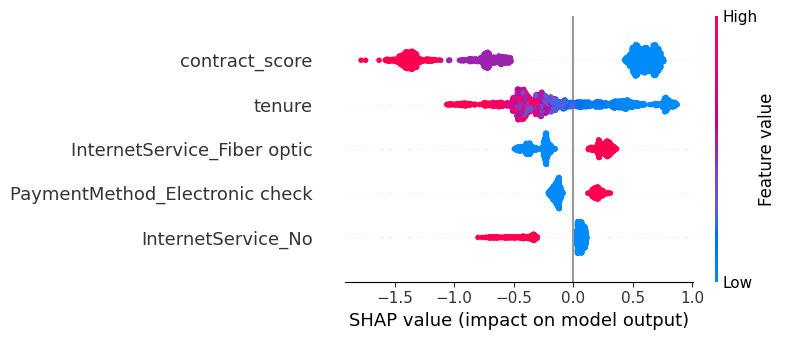

In [10]:
import shap
# SHAP explainerを作成（Treeモデル専用）
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
# SHAP summary plot（特徴量ごとの影響を可視化(上位５位)）
shap.summary_plot(shap_values, X_test,max_display=5)

In [11]:
#【参考】予測結果をCSVファイルに保存しローカルにダウンロード

# === ✅ 予測スコア（確率）をデータフレームに追加 ===
df_result = df.loc[X_test.index, ['customerID', 'tenure', 'MonthlyCharges']].copy()
df_result['predicted_score'] = y_prob  # y_prob は predict_proba で得たスコア（1クラス目）

# === ✅ CSVに出力 ===
from google.colab import files
# CSVファイルを保存
df_result.to_csv('predicted_scores.csv', index=False)

# ダウンロードをトリガー
files.download('predicted_scores.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

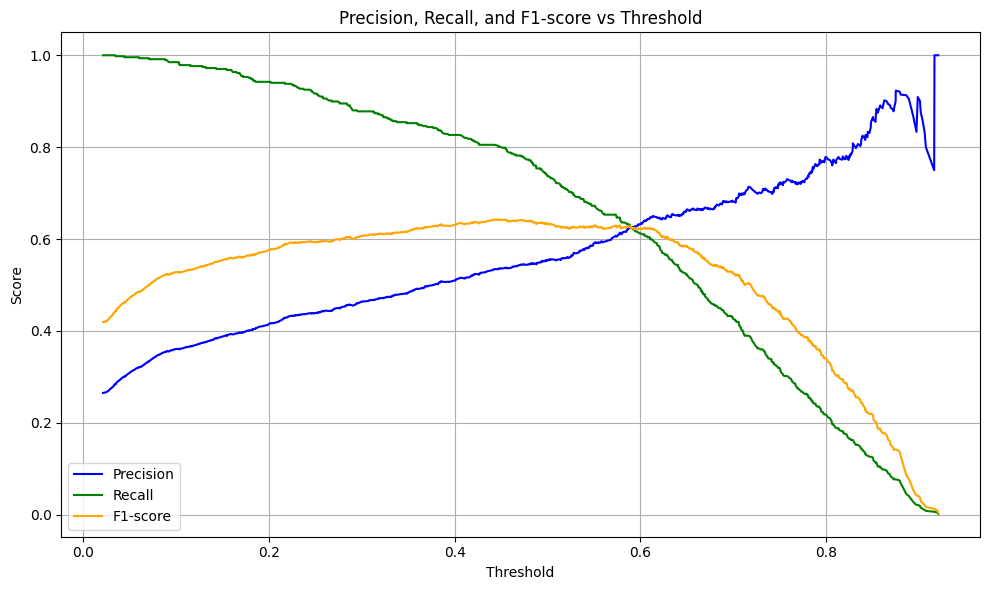

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# 特定の条件を満たすしきい値を見つける
target_precision = 0.62
best_threshold = next((t for p, t in zip(precision, thresholds) if p >= target_precision), 0.5)
# Precision, Recall, Thresholds を算出
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# F1-score を計算（しきい値の数に合わせて precision[:-1], recall[:-1]）
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)

# F1-score 最大のしきい値を取得
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# グラフプロット
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.plot(thresholds, f1_scores, label="F1-score", color='orange')
plt.title("Precision, Recall, and F1-score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


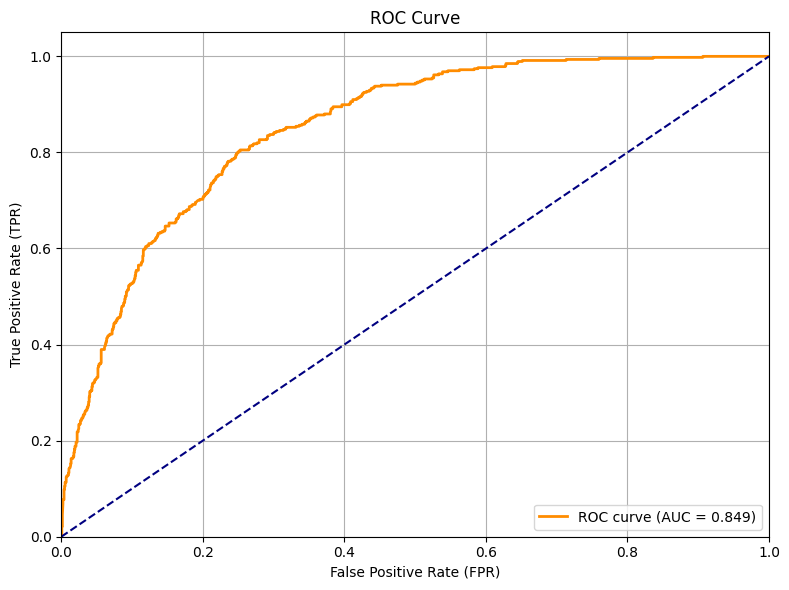

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# FPR, TPR, しきい値を計算
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)

# AUCスコアの計算
roc_auc = roc_auc_score(y_test, y_prob)

# グラフ描画
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # ダミーのランダム分類線
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
